This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Modern convnet architecture patterns

### Modularity, hierarchy, and reuse

### Residual connections

**Residual block where the number of filters changes**

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

**Case where target block includes a max pooling layer**

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 32)   896         ['rescaling[0][0]']              
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d_6[0][0]']               
                                                                                              

### Batch normalization

### Depthwise separable convolutions

### Putting it together: A mini Xception-like model

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"edmonsahakyan","key":"3bb9ab4df24490f8509a77af0944671e"}'}

In [9]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [23]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [24]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [25]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 31s 188ms/step - loss: 0.7008 - accuracy: 0.5600 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 10s 160ms/step - loss: 0.6543 - accuracy: 0.6125 - val_loss: 0.6974 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 9s 142ms/step - loss: 0.6585 - accuracy: 0.6075 - val_loss: 0.6950 - val_accuracy: 0.5020
Epoch 4/100
63/63 [==============================] - 9s 144ms/step - loss: 0.6354 - accuracy: 0.6445 - val_loss: 0.7404 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 9s 143ms/step - loss: 0.6182 - accuracy: 0.6680 - val_loss: 0.7462 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 10s 154ms/step - loss: 0.5993 - accuracy: 0.6740 - val_loss: 0.7720 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 9s 140ms/step - loss: 0.5931 - accuracy: 0.6790 - val_loss: 0.7694 - val_accuracy: 0.5

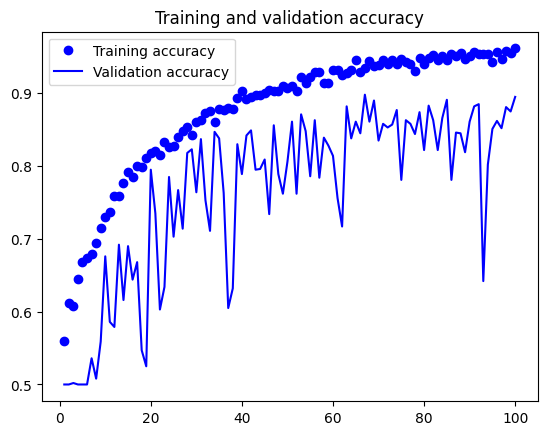

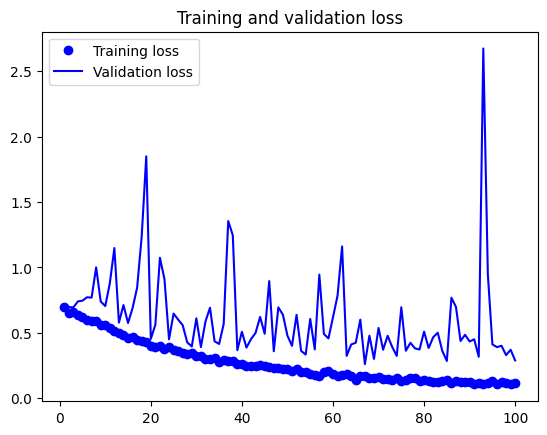

In [26]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [27]:
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 59ms/step - loss: 0.4526 - accuracy: 0.8205
Test accuracy: 0.821
